<a href="https://www.kaggle.com/code/bonsoularani/a-b-testing-ad-campaigns?scriptVersionId=180378219" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import plotly.express as px
import optuna
import matplotlib.pyplot as plt
import math

from colorama import Fore, Style, init;
# Import necessary libraries
from IPython.display import display, HTML
from scipy.stats import skew  # Import the skew function
# Import Plotly.go
import plotly.graph_objects as go
# import Subplots
from plotly.subplots import make_subplots

palette = ['#422057FF', '#fafa00']
color_palette = sns.color_palette(palette)
# Remove Warnings
import warnings 
warnings.filterwarnings("ignore")
# Set the option to display all columns
pd.set_option('display.max_columns', None)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ab-testing-dataset/kindle AB testing dataset.xlsx


<div style="background-color: #c2a462; padding: 20px;">
<a id="Import"></a>
<p style="background-color: #024602; font-family: 'sans-serif'; color: #FDDB27FF; font-size: 300%; text-align: center; border-radius: 600px 120px;">Kindle Ad Campaigns</p>

<ol>
    <li style="font-size: 120%;">Campaign AKIN9326 focuses on promoting the long-term benefits of reading in one's professional life and emphasizes how Kindle can facilitate reading.</li>
    <li style="font-size: 120%;">Campaign AKIN8012 aims to instill fear in people's minds about the potential negative impact on their professional career if they don't read regularly.</li>



<div style="background-color: #047848; padding: 20px;">
<a id="Import"></a>
<p style="background-color: #030303; font-family: 'serif'; color: #fcfcfc; font-size: 300%; text-align: center; border-radius: 1000px 10px;">GOAL/OBJECTIVE</p>

<ol>
    <li style="font-size: 120%; color: #04fae8;"">The primary goal is to determine which ad campaign, AKIN9326 or AKIN8012, resulted in more conversions for the Kindle product.</li>
    <li style="font-size: 120%; color: #04fae8;">Conversions serve as a key metric for evaluating the effectiveness of each ad campaign in driving user engagement and sales.</li>
    <li style="font-size: 120%; color: #04fae8;">A higher conversion rate suggests that more users took the desired action, such as purchasing a Kindle, in response to the ad campaign.</li>
    <li style="font-size: 120%; color: #04fae8;">Comparing the cost per conversion between the two campaigns can provide insights into the efficiency of acquiring new customers.</li>
    <li style="font-size: 120%; color: #04fae8;">Analyzing the Click Through Rate (CTR) helps assess the relevance and appeal of each ad, potentially influencing conversion rates.</li>
    <li style="font-size: 120%; color: #04fae8;">The number of ad clicks is another factor to consider, as it may correlate with higher conversion rates if the ad content resonates with users.</li>
    <li style="font-size: 120%; color: #04fae8;">Efforts should be made to optimize ad expenditure while maximizing conversions to achieve the best return on investment.</li>
    <li style="font-size: 120%; color: #04fae8;">Preference is given to ad campaigns with higher values of Total Conversions and Total Approved Conversions, indicating successful customer acquisition.</li>
</ol>


In [2]:
df = pd.read_excel("/kaggle/input/ab-testing-dataset/kindle AB testing dataset.xlsx")

In [3]:

def print_boxed_blue_heading(heading):
    gradient = [Fore.RED, Fore.YELLOW, Fore.GREEN, Fore.CYAN, Fore.BLUE, Fore.MAGENTA]
    print("\n" + "=" * (len(heading) + 4))
    words = heading.split()
    for i, word in enumerate(words):
        if i == len(words) - 1:
            print(f"| {gradient[len(word) % len(gradient)] + word + Style.RESET_ALL} |")
        else:
            print(f"| {gradient[len(word) % len(gradient)] + word + Style.RESET_ALL}", end=" ")
    print("=" * (len(heading) + 4))

def print_error(message):
    raise ValueError(message)

def D_O(train_df):
    try:

        # Display head of the training dataset nicely
        print_boxed_blue_heading("The Head Of Dataset is:")
        display(HTML(train_df.head(5).to_html(index=False).replace('<table border="1" class="dataframe">', '<table style="border: 2px solid blue;">').replace('<td>', '<td style="color: skyblue;">')))
        print('\n')

        # Display tail of the training dataset nicely
        print_boxed_blue_heading("The Tail Of Dataset is:")
        display(HTML(train_df.tail(5).to_html(index=False).replace('<table border="1" class="dataframe">', '<table style="border: 2px solid blue;">').replace('<td>', '<td style="color: skyblue;">')))
        print('\n')

        print_boxed_blue_heading("Shape Data:")
        print(f'The Shape of the Data is {train_df.shape} |')
        print(f'- 1.The No of Rows is {train_df.shape[0]} |')
        print(f'- 2.The No of Cols is {train_df.shape[1]}|')
        
        print('\n')
        
        print_boxed_blue_heading("Info Of Train Data:")
        train_df.info()

        # Describe both numerical and categorical data
        print_boxed_blue_heading("Numerical Summary of Data:")
        print(f"\n{Style.BRIGHT + Fore.LIGHTBLUE_EX}The Numerical Summary of Data is:{Style.RESET_ALL}")
        display(train_df.describe().style.set_caption("Data Summary").set_table_styles([{'selector': 'caption', 'props': [('color', 'skyblue')]}]))

        Cat_cols_train = [col for col in train_df.columns if train_df[col].dtype == 'O']
        print_boxed_blue_heading("Categorical Columns of Data:")
        print(f'\n{Style.BRIGHT + Fore.LIGHTBLUE_EX}The Categorical Columns of Data are :{Style.RESET_ALL} {Cat_cols_train}')

        N_cols_train = [col for col in train_df.columns if train_df[col].dtype == 'float']
        print_boxed_blue_heading("Numerical Columns of Data:")
        print(f'\n{Style.BRIGHT + Fore.LIGHTBLUE_EX}The Numerical Columns of Data are :{Style.RESET_ALL} {N_cols_train}\n')

        print_boxed_blue_heading("Null Values in Data:")
        print(f'\n{Style.BRIGHT + Fore.LIGHTBLUE_EX}The Null Values of Data are:{Style.RESET_ALL}\n{train_df.isnull().sum()}')

        print_boxed_blue_heading("Duplicates Check in Data:")
        if train_df.duplicated().any():
            print(f'\n{Style.BRIGHT + Fore.LIGHTBLUE_EX}Duplicates exist in the dataset.{Style.RESET_ALL}')
        else:
            print(f'\n{Style.BRIGHT + Fore.LIGHTBLUE_EX}No duplicates found in the dataset.{Style.RESET_ALL}')

        print('\n' + "=" * 100 + '\n')

        
    except Exception as e:
        print_error

In [4]:
D_O(df)


| The | Head | Of | Dataset | is: |


ad_id,campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
1121121,AKIN9326,30-34,M,Business & industry,323899,46,78.920000,5,1
1121091,AKIN9326,30-34,M,Business & industry,1194718,141,254.049996,3,1
1121092,AKIN9326,30-34,M,Business & industry,637648,67,122.400000,3,0
1121094,AKIN9326,30-34,M,Business & industry,24362,0,0.000000,1,1
1121095,AKIN9326,30-34,M,Business & industry,459690,50,86.330001,3,2





| The | Tail | Of | Dataset | is: |


ad_id,campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
1314303,AKIN8012,30-34,M,Entertainment (Reading),496760,42,61.009999,10,3
1121246,AKIN8012,30-34,M,Business & industry,105047,13,20.209999,3,1
1314393,AKIN8012,40-44,F,Entertainment (Reading),877535,149,217.779997,5,2
1121824,AKIN8012,30-34,F,Business & industry,1705246,295,429.479998,23,10
1121336,AKIN8012,35-39,M,Business & industry,275080,43,69.660000,4,3





| Shape | Data: |
The Shape of the Data is (1250, 10) |
- 1.The No of Rows is 1250 |
- 2.The No of Cols is 10|



| Info | Of | Train | Data: |
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ad_id                1250 non-null   int64  
 1   campaign_id          1250 non-null   object 
 2   age                  1250 non-null   object 
 3   gender               1250 non-null   object 
 4   interest             1250 non-null   object 
 5   Impressions          1250 non-null   int64  
 6   Clicks               1250 non-null   int64  
 7   Spent                1250 non-null   float64
 8   Total_Conversion     1250 non-null   int64  
 9   Approved_Conversion  1250 non-null   int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 97.8+ KB

| Numerical | Summary | of | Data: |

The Numerical Summary of Data is:


,ad_id,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000
mean,993477.958400,192656.500800,34.439200,52.822048,2.227200,0.605600
std,191940.556393,319782.371565,58.504651,88.814661,2.999797,0.967263
min,708771.000000,87.000000,0.000000,0.000000,0.000000,0.000000
25%,778264.000000,7310.000000,1.000000,1.540000,1.000000,0.000000
50%,1121212.000000,56044.000000,9.000000,13.410000,1.000000,0.000000
75%,1121816.750000,227812.000000,38.750000,61.009999,2.000000,1.000000
max,1314415.000000,3052003.000000,421.000000,639.949998,38.000000,13.000000



| Categorical | Columns | of | Data: |

The Categorical Columns of Data are : ['campaign_id', 'age', 'gender', 'interest']

| Numerical | Columns | of | Data: |

The Numerical Columns of Data are : ['Spent']


| Null | Values | in | Data: |

The Null Values of Data are:
ad_id                  0
campaign_id            0
age                    0
gender                 0
interest               0
Impressions            0
Clicks                 0
Spent                  0
Total_Conversion       0
Approved_Conversion    0
dtype: int64

| Duplicates | Check | in | Data: |

Duplicates exist in the dataset.




In [5]:
#drop_duplicates
df.drop_duplicates(keep='first',inplace=True)

In [6]:
cat_columns = df.select_dtypes(include=['object'])

#calculate the frequency of category columns
frequency_counts = {}

for column in cat_columns:
    frequency_counts[column] = df[column].value_counts()
    
    
# print the frequency counts for each categorical column
for column, counts in frequency_counts.items():
    print_boxed_blue_heading(f"Frequency counts for {column}:")
    print(counts)
    print()
    
    


| Frequency | counts | for | campaign_id: |
campaign_id
AKIN9326    626
AKIN8012    554
Name: count, dtype: int64


| Frequency | counts | for | age: |
age
30-34    436
45-49    272
35-39    251
40-44    221
Name: count, dtype: int64


| Frequency | counts | for | gender: |
gender
M    612
F    568
Name: count, dtype: int64


| Frequency | counts | for | interest: |
interest
Business & industry        964
Entertainment (Games)      124
Entertainment (Reading)     92
Name: count, dtype: int64



In [7]:
cat_columns

,campaign_id,age,gender,interest
0,AKIN9326,30-34,M,Business & industry
1,AKIN9326,30-34,M,Business & industry
2,AKIN9326,30-34,M,Business & industry
3,AKIN9326,30-34,M,Business & industry
4,AKIN9326,30-34,M,Business & industry
...,...,...,...,...
1245,AKIN8012,30-34,M,Entertainment (Reading)
1246,AKIN8012,30-34,M,Business & industry
1247,AKIN8012,40-44,F,Entertainment (Reading)
1248,AKIN8012,30-34,F,Business & industry


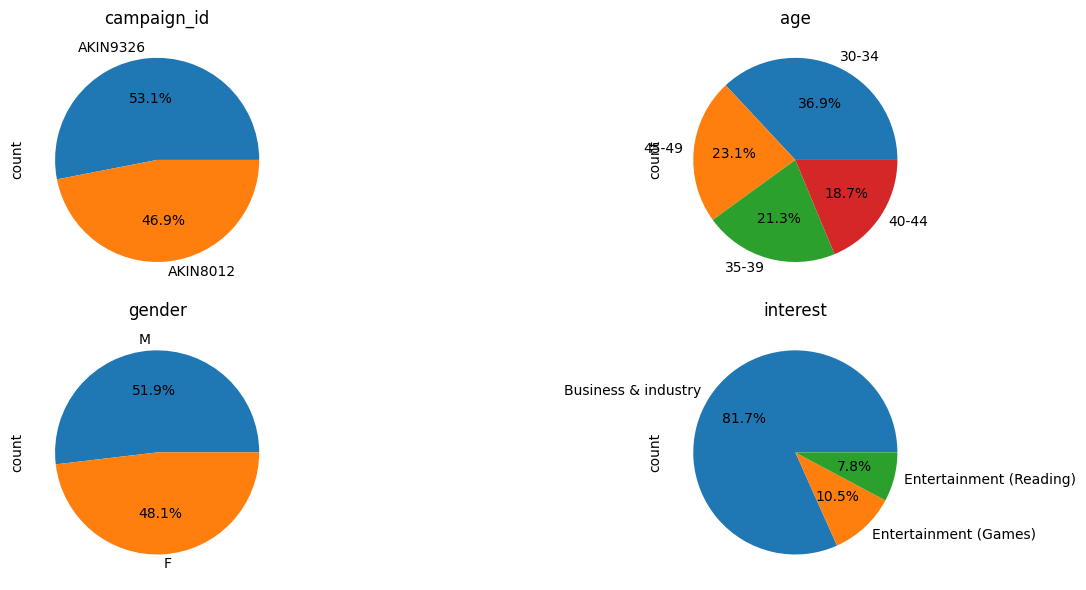

In [8]:
cat_columns = ['campaign_id','age','gender','interest']

#calculate  the number of rows and columns based on the number of categotical columns and suplots
num_cols = 2
num_rows = (len(cat_columns) + num_cols - 1) // num_cols

#create a figure and a set of subplots
fig,axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

#iterate through each categorical column and plot a pie chart
for i, col in enumerate(cat_columns):
    ax = axes[i // num_cols, i %  num_cols] #select the subplot based on the index
    df[col].value_counts().plot.pie(ax=ax,autopct='%1.1f%%')
    ax.set_title(col)
    
for j in range(len(cat_columns),num_rows *num_cols):
    axes.flatten()[j].axis('off')
    
#adjust the spacing
plt.tight_layout()

<a id="Import"></a>
# <p style="background-color: hashtag#422057FF; font-family: 'Copperplate'; color:hashtag#FDDB27FF; font-size:140%; text-align:center; border-radius:1000px 10px;">Reading The Dataset</p>

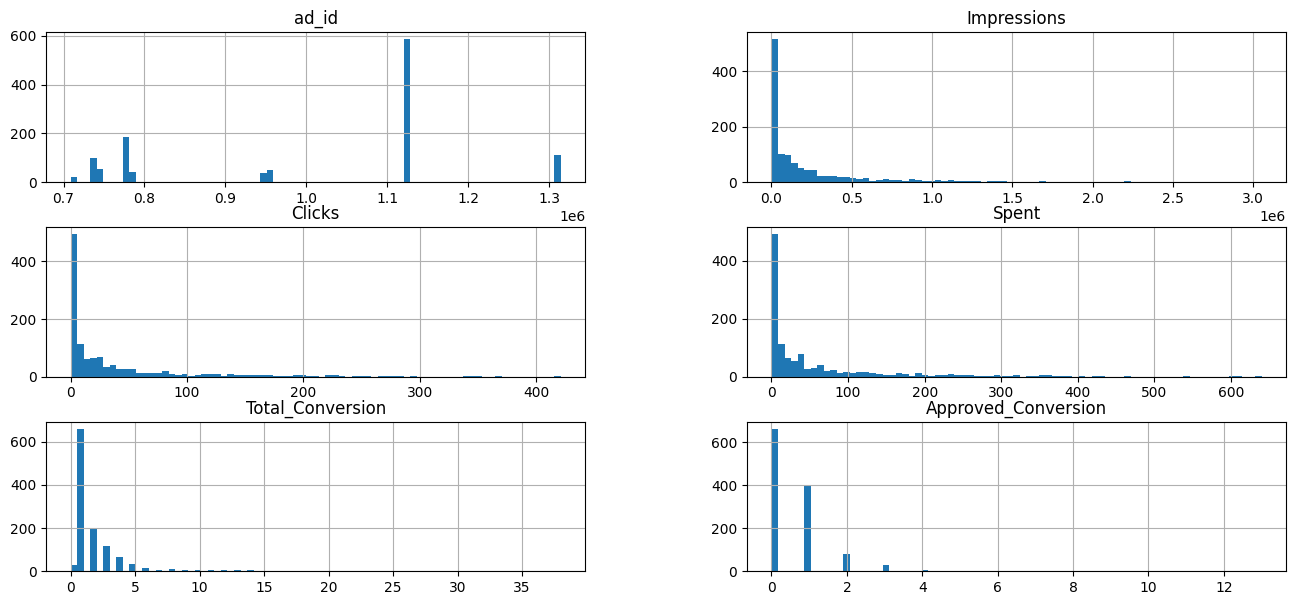

In [9]:
#data distributions for numeric columns
df.hist(bins=75,figsize=(16,7))

plt.show()

In [10]:
#chi-squre test - testing the significant difference in unique instances of the two campaigns
from scipy.stats import chi2_contingency

#create a contingency
contingency_table = pd.crosstab(index = df['campaign_id'],columns='count')

#perform the chi-square test
chi1,p_value,_,_ = chi2_contingency(contingency_table)

#print the results
print_boxed_blue_heading(f"Chi-Square Statistic {chi1}")
print_boxed_blue_heading(f"P-Value: {p_value}")

#determine significance level
alpha = 0.05
if p_value <= alpha:
    print_boxed_blue_heading(f"There is significant difference between the categories in the Campaign ID")
else:
    print_boxed_blue_heading(f"There is no significance differencebetwwen the categories in the Campaign ID")
    


| Chi-Square | Statistic | 0.0 |

| P-Value: | 1.0 |

| There | is | no | significance | differencebetwwen | the | categories | in | the | Campaign | ID |


<a id="Import"></a>
# <p style="background-color: hashtag#422057FF; font-family: 'Copperplate'; color:hashtag#FDDB27FF; font-size:140%; text-align:center; border-radius:1000px 10px;">Feature Engineering</p>

## Adding other columns based on the columns we have

#### Adding cick through rate CTR =  (clicks/impressions)





In [11]:
#calculate CTR, handling the division by zero
df['CTR'] = np.where((df['Clicks'] == 0) | (df['Impressions'] == 0), np.nan,(df['Clicks']/df['Impressions']) * 100)

df.head(10)

,ad_id,campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,CTR
0,1121121,AKIN9326,30-34,M,Business & industry,323899,46,78.920000,5,1,0.014202
1,1121091,AKIN9326,30-34,M,Business & industry,1194718,141,254.049996,3,1,0.011802
2,1121092,AKIN9326,30-34,M,Business & industry,637648,67,122.400000,3,0,0.010507
3,1121094,AKIN9326,30-34,M,Business & industry,24362,0,0.000000,1,1,NaN
4,1121095,AKIN9326,30-34,M,Business & industry,459690,50,86.330001,3,2,0.010877
5,1121096,AKIN9326,30-34,M,Business & industry,750060,86,161.909999,2,1,0.011466
6,1121097,AKIN9326,30-34,M,Business & industry,30068,1,1.820000,1,0,0.003326
7,1121098,AKIN9326,30-34,M,Business & industry,1267550,123,236.769999,4,1,0.009704
8,1121100,AKIN9326,30-34,M,Business & industry,3052003,340,639.949998,5,1,0.011140
9,1121101,AKIN9326,30-34,M,Business & industry,29945,1,1.590000,2,1,0.003339


### Conversion Rate

In [12]:
df['Conversion Rate'] = np.where((df['Approved_Conversion'] == 0) | (df['Total_Conversion'] == 0), np.nan,(df['Approved_Conversion']/df['Total_Conversion']) * 100)

df.head(10)

,ad_id,campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,CTR,Conversion Rate
0,1121121,AKIN9326,30-34,M,Business & industry,323899,46,78.920000,5,1,0.014202,20.000000
1,1121091,AKIN9326,30-34,M,Business & industry,1194718,141,254.049996,3,1,0.011802,33.333333
2,1121092,AKIN9326,30-34,M,Business & industry,637648,67,122.400000,3,0,0.010507,NaN
3,1121094,AKIN9326,30-34,M,Business & industry,24362,0,0.000000,1,1,NaN,100.000000
4,1121095,AKIN9326,30-34,M,Business & industry,459690,50,86.330001,3,2,0.010877,66.666667
5,1121096,AKIN9326,30-34,M,Business & industry,750060,86,161.909999,2,1,0.011466,50.000000
6,1121097,AKIN9326,30-34,M,Business & industry,30068,1,1.820000,1,0,0.003326,NaN
7,1121098,AKIN9326,30-34,M,Business & industry,1267550,123,236.769999,4,1,0.009704,25.000000
8,1121100,AKIN9326,30-34,M,Business & industry,3052003,340,639.949998,5,1,0.011140,20.000000
9,1121101,AKIN9326,30-34,M,Business & industry,29945,1,1.590000,2,1,0.003339,50.000000


### Cost per Conversion

In [13]:
df['Cost Per Conversion']  = np.where((df['Spent'] == 0) | (df['Approved_Conversion'] == 0), np.nan,(df['Spent']/df['Approved_Conversion']) * 100)

df.head()

,ad_id,campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,CTR,Conversion Rate,Cost Per Conversion
0,1121121,AKIN9326,30-34,M,Business & industry,323899,46,78.920000,5,1,0.014202,20.000000,7892.000020
1,1121091,AKIN9326,30-34,M,Business & industry,1194718,141,254.049996,3,1,0.011802,33.333333,25404.999600
2,1121092,AKIN9326,30-34,M,Business & industry,637648,67,122.400000,3,0,0.010507,NaN,NaN
3,1121094,AKIN9326,30-34,M,Business & industry,24362,0,0.000000,1,1,NaN,100.000000,NaN
4,1121095,AKIN9326,30-34,M,Business & industry,459690,50,86.330001,3,2,0.010877,66.666667,4316.500056


<a id="Import"></a>
# <p style="background-color: hashtag#422057FF; font-family: 'Copperplate'; color:hashtag#FDDB27FF; font-size:140%; text-align:center; border-radius:1000px 10px;">EDA</p>

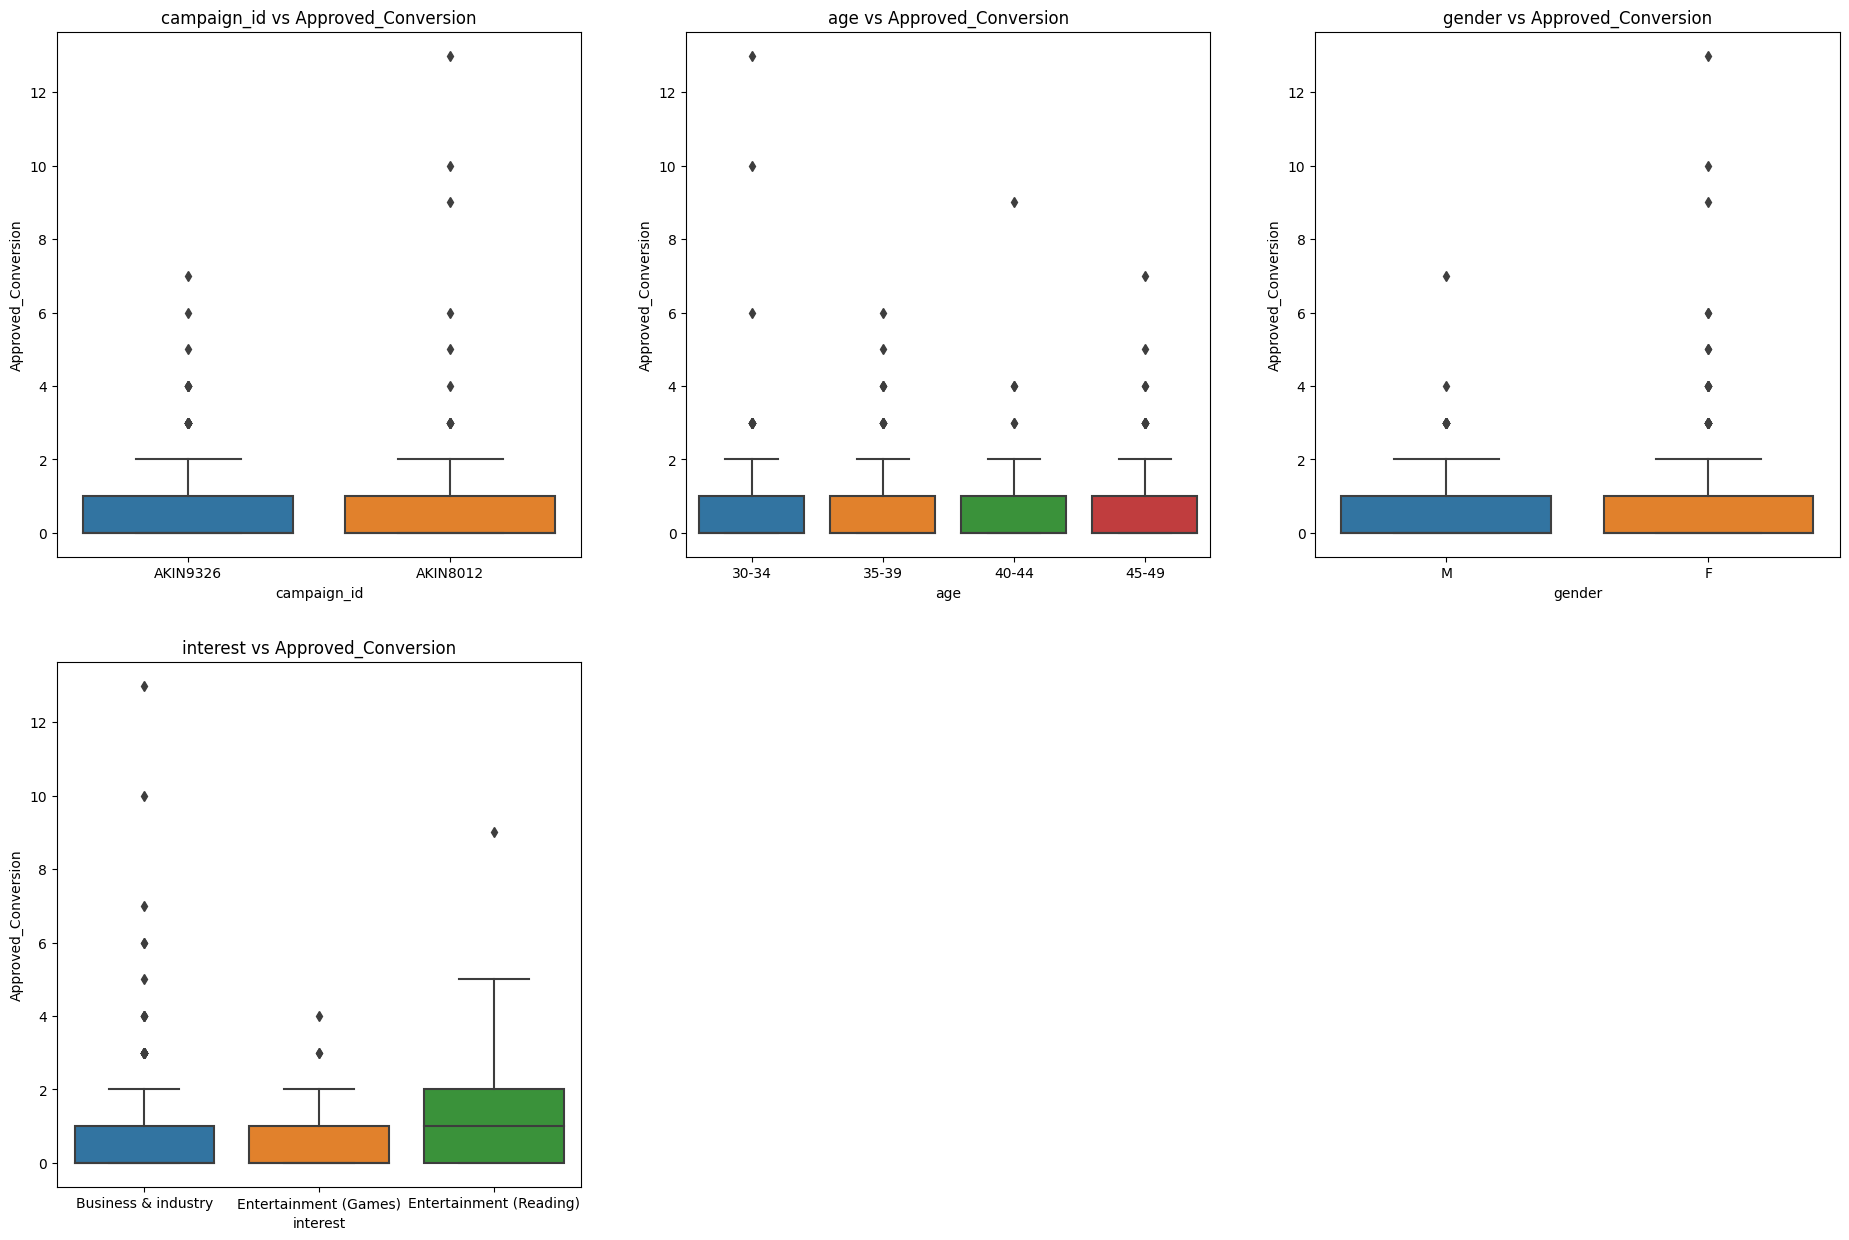

In [14]:
#BOX PLOT
#set the figure size for the plots
plt.figure(figsize=(23,15))

#select categorical columns excluding 'Product ID' from the dataframe.
categorical_columns = [col for col in df.select_dtypes('object').columns if col != 'ad_id']

#loop through each categorical column plotting
for i ,col in enumerate(categorical_columns):
    #create subplots with 2 rows,3 columns
    plt.subplot(2,3,i+1)
    
    #create a boxplot with x-axis as the current categorical columns and y-axis  as Approved Conversions
    sns.boxplot(x=df[col],y=df['Approved_Conversion'])
    
    #set the title of the subplot to show the current categorical column and Approved Conversion
    plt.title(f'{col} vs Approved_Conversion')

## Correlation Matrix

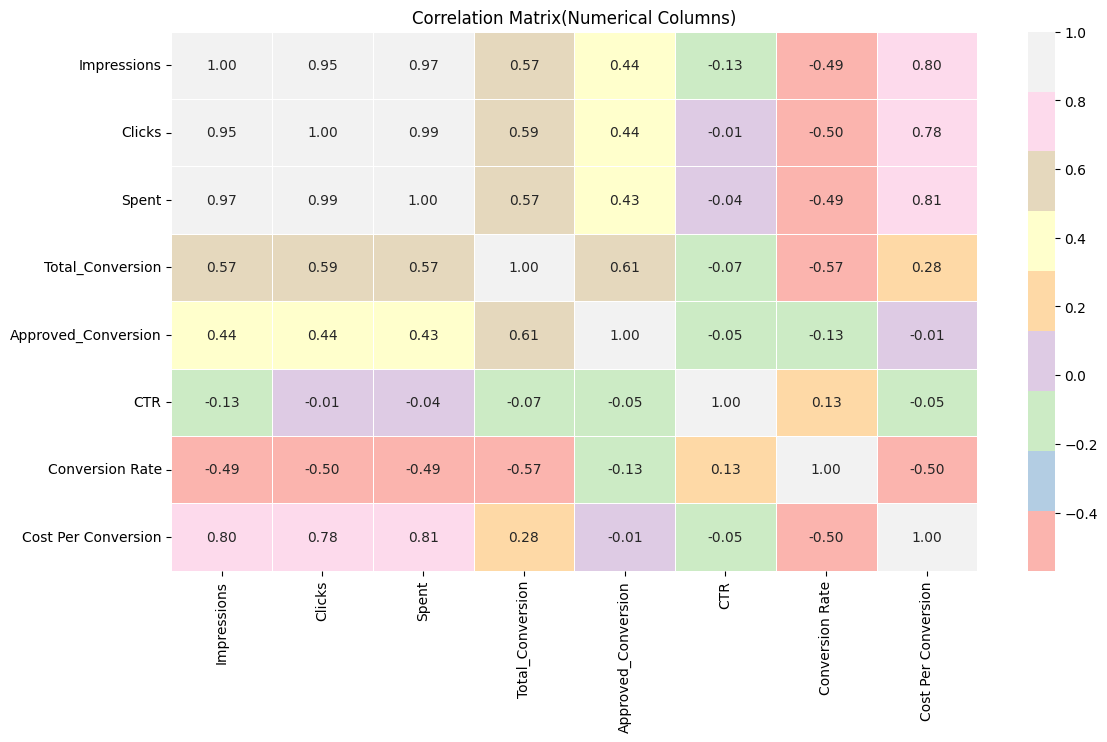

In [15]:
#select categorical columns excluding 'Product ID' from the dataframe.
numerical_columns = [col for col in df.select_dtypes('number').columns if col != 'ad_id']

correlation_matrix = df[numerical_columns].corr()

#plot the correlation matrix as a heatmap
plt.figure(figsize=(13,7))
sns.heatmap(correlation_matrix,annot=True,cmap='Pastel1',fmt=".2f",linewidth=.5)
plt.title("Correlation Matrix(Numerical Columns)")
plt.show()

# **Perfomance**

<a id="Import"></a>
<p style="background-color: #422057FF; font-family: 'Copperplate'; color: #FDDB27FF; font-size: 160%; text-align: center; border-radius: 1000px 10px;">Campaign ID</p>

<ol>
    <li style="font-size: 120%;">The higher your conversion rate, the more effective your ad campaign</li>
    <li style="font-size: 120%;">A higher cost per conversion clearly indicates that obtaining your real customer is getting expensive</li>
    <li style="font-size: 120%;">A higher CTR is a good indication that users find your ads and listings helpful and relevant.</li>
    <li style="font-size: 120%;">The higher the ad clicks, the more successful the ad.</li>
    <li style="font-size: 120%;">Prefer less expenditure.</li>
    <li style="font-size: 120%;">Total Conversions and Total Approved Conversions high values preferred.</li>
</ol>

In [16]:
campaign_type = df.groupby(['campaign_id']).agg(
    {'Impressions': 'sum','Clicks':'sum','Spent':'sum','Total_Conversion':'sum','Approved_Conversion':'sum',
    'CTR':'mean','Conversion Rate':'mean','Cost Per Conversion':'mean'}).reset_index()

campaign_type.columns = ['Campaign ID','Total AD Impressions','Total Ad Clicks','Total Ad Expenditure',
                        'Total Conversions','Total Approved Conversions','Avg.CTR','Avg.Cost Per Conversion','Avg.Conversion Rate']

campaign_type

,Campaign ID,Total AD Impressions,Total Ad Clicks,Total Ad Expenditure,Total Conversions,Total Approved Conversions,Avg.CTR,Avg.Cost Per Conversion,Avg.Conversion Rate
0,AKIN8012,34295216,6617,9827.529982,891,290,0.024578,84.391655,2203.466059
1,AKIN9326,205147615,36114,55741.069959,1810,437,0.016535,58.355654,8251.197851



<h2 style="color: #422057FF;">Insights</h2>

<ol>
    <li style="color: #008000;">Campaign ID <strong style="color: #FF5733;">AKIN9326</strong> ranks top in Total Ad Clicks, Total Ad Expenditure, Total Conversions, and Total Approved Conversions.</li>
    <li style="color: #008000;">Campaign ID <strong style="color: #FF5733;">AKIN8012</strong> has the highest Click Through Rate and a lower cost per conversion,conversion rate, cost per conversion.</li>
</ol>


In [17]:
#plotting a grouped bar graph
fig = px.bar(campaign_type,x='Campaign ID',y=['Total AD Impressions','Total Ad Clicks','Total Ad Expenditure',
                        'Total Conversions','Total Approved Conversions','Avg.CTR','Avg.Cost Per Conversion','Avg.Conversion Rate'],
             labels={'value':'Total'}, title='Campaign ID Perfomance',barmode='group')

#update layout to vary length and width
fig.update_layout(width=1000,height=500,bargap=0.2)

fig.show()

In [18]:
Age = df.groupby(['age']).agg({'Impressions': 'sum','Clicks':'sum','Spent':'sum','Total_Conversion':'sum','Approved_Conversion':'sum',
    'CTR':'mean','Conversion Rate':'mean','Cost Per Conversion':'mean'}).reset_index()

#rename columns for clarity
Age.columns = ['Age Group','Total AD Impressions','Total Ad Clicks','Total Ad Expenditure',
                        'Total Conversions','Total Approved Conversions','Avg.CTR','Avg.Cost Per Conversion','Avg.Conversion Rate']

Age

,Age Group,Total AD Impressions,Total Ad Clicks,Total Ad Expenditure,Total Conversions,Total Approved Conversions,Avg.CTR,Avg.Cost Per Conversion,Avg.Conversion Rate
0,30-34,77091917,10876,17355.079984,938,267,0.015509,76.548502,4927.393599
1,35-39,45843178,7635,11992.739993,523,162,0.018504,70.408083,4784.319513
2,40-44,44823435,8675,12989.919975,543,129,0.022154,67.177986,6114.763582
3,45-49,71684301,15545,23230.859989,697,169,0.023566,59.467182,9189.741118


In [19]:
#plotting a grouped bar graph
fig = px.bar(Age,x='Age Group',y=['Total AD Impressions','Total Ad Clicks','Total Ad Expenditure',
                        'Total Conversions','Total Approved Conversions','Avg.CTR','Avg.Cost Per Conversion','Avg.Conversion Rate'],
             labels={'value':'Total'}, title='AD Perfomance According to Age',barmode='group')

#update layout to vary length and width
fig.update_layout(width=1000,height=500,bargap=0.2)

fig.show()

### Total Approved Conversions with Age Group

In [20]:
#grouping  the data by Camapign ID and Age Group then aggregating the desired  metrics
campaign_age = df.groupby(['campaign_id','age']).agg({'Approved_Conversion':'sum'}).reset_index()

#renaming the aggregated columns
campaign_age.columns = ['Campaign ID','age','Total Approved Conversions']

#display
campaign_age

,Campaign ID,age,Total Approved Conversions
0,AKIN8012,30-34,142
1,AKIN8012,35-39,51
2,AKIN8012,40-44,41
3,AKIN8012,45-49,56
4,AKIN9326,30-34,125
5,AKIN9326,35-39,111
6,AKIN9326,40-44,88
7,AKIN9326,45-49,113


In [21]:
#plotting a grouped bar graph
fig = px.bar(campaign_age,x='Campaign ID',y='Total Approved Conversions',color='age',labels={'value':'Total'}, title='Grouped Bar Graph of Ad Metrics by Campaign ID and Age Group',barmode='group')

#update layout to vary length and width
fig.update_layout(width=1000,height=500,bargap=0.2)

fig.show()

<h2 style="color: #422057;">Insights</h2>

<ul>
    <li style="color: #008000;">AKIN8012 performs better for age group <strong style="color: #FF5733;">30-34</strong></li>
    <li style="color: #008000;">AKIN9326 performs better for age groups <strong style="color: #FF5733;">35-39, 40-44, 45-49</strong></li>
</ul>


### Gender

In [22]:
Gender = df.groupby(['gender']).agg({'Impressions': 'sum','Clicks':'sum','Spent':'sum','Total_Conversion':'sum','Approved_Conversion':'sum',
    'CTR':'mean','Conversion Rate':'mean','Cost Per Conversion':'mean'}).reset_index()

#rename columns for clarity
Gender.columns = ['Gender','Total AD Impressions','Total Ad Clicks','Total Ad Expenditure',
                        'Total Conversions','Total Approved Conversions','Avg.CTR','Avg.Cost Per Conversion','Avg.Conversion Rate']

Gender

,Gender,Total AD Impressions,Total Ad Clicks,Total Ad Expenditure,Total Conversions,Total Approved Conversions,Avg.CTR,Avg.Cost Per Conversion,Avg.Conversion Rate
0,F,131664114,27154,39208.259947,1584,387,0.022629,64.642286,6712.272689
1,M,107778717,15577,26360.339995,1117,340,0.016532,74.027968,5660.949842


In [23]:
#plotting a grouped bar graph
fig = px.bar(Gender,x='Gender',y=['Total Ad Clicks','Total Ad Expenditure',
                        'Total Conversions','Total Approved Conversions','Avg.CTR','Avg.Cost Per Conversion','Avg.Conversion Rate'],
             labels={'value':'Total'}, title='AD Perfomance According to Age',barmode='group')

#update layout to vary length and width
fig.update_layout(width=1000,height=500,bargap=0.2)

fig.show()

### Total Approved Conversions with Gender

In [24]:
#grouping  the data by Camapign ID and Age Group then aggregating the desired  metrics
Gender = df.groupby(['gender','campaign_id']).agg({'Approved_Conversion':'sum'}).reset_index()

#renaming the aggregated columns
Gender.columns = ['Gender','Campaign ID','Total Approved Conversions']

#display
Gender

,Gender,Campaign ID,Total Approved Conversions
0,F,AKIN8012,163
1,F,AKIN9326,224
2,M,AKIN8012,127
3,M,AKIN9326,213


In [25]:
#plotting a grouped bar graph
fig = px.bar(Gender,x='Campaign ID',y='Total Approved Conversions',color='Gender',labels={'value':'Total'}, title='AD Perfomance According to Gender',barmode='group')

#update layout to vary length and width
fig.update_layout(width=1000,height=500,bargap=0.2)

fig.show()


<h2 style="color: #33ff36;">Insights</h2>

<ol>
    <li style="color: #FFBF00;"> AKIN8012 performs poor with 163 F and 127 M Conversions </li>
    <li style="color: #40E0D0;"> AKIN9326 performs better with 224 F and 213 M Conversions</li>
</ol>


### Total Approved Conversions on Audience Interest

In [26]:
campaign_audience = df.groupby(['campaign_id','interest']).agg({'Approved_Conversion':'sum'}).reset_index()

#rename columns
campaign_audience.columns = ['Campaign ID','Audience Interest','Total Approved Conversion']

campaign_audience

,Campaign ID,Audience Interest,Total Approved Conversion
0,AKIN8012,Business & industry,239
1,AKIN8012,Entertainment (Games),21
2,AKIN8012,Entertainment (Reading),30
3,AKIN9326,Business & industry,321
4,AKIN9326,Entertainment (Games),51
5,AKIN9326,Entertainment (Reading),65


In [27]:
#plotting a grouped bar graph
fig = px.bar(campaign_audience,x='Campaign ID',y='Total Approved Conversion',color='Audience Interest',labels={'value':'Total'}, title='AD Perfomance According To Audience Interest',barmode='group')

#update layout to vary length and width
fig.update_layout(width=1000,height=500,bargap=0.2)

fig.show()


<h2 style="color: #ec9107;">Insights(Total Approved Conversions)</h2>

<ol>
    <li style="color: #0787ec;"> AKIN9326 performs better for all audience of interest</li>
</ol>


### Cost Effective Campaign

In [28]:
campaign_type = df.groupby(['campaign_id']).agg({'Cost Per Conversion':'mean'}).reset_index()

#rename
campaign_type.columns = ['Campaign ID','Avg.Cost Per Conversion']

campaign_type

,Campaign ID,Avg.Cost Per Conversion
0,AKIN8012,2203.466059
1,AKIN9326,8251.197851


In [29]:
#plotting a grouped bar graph
fig = px.bar(campaign_type,x='Campaign ID',y='Avg.Cost Per Conversion',color='Campaign ID',labels={'value':'Total'}, title='Cost Effective Campaign',barmode='group')

#update layout to vary length and width
fig.update_layout(width=800,height=500,bargap=0.2)

fig.show()


<h2 style="color: #ec9107;">Insights(Total Approved Conversions)</h2>

<ol>
    <li style="color: #0787ec;"> AKIN9326 is the most Cost Effective Campaign</li>
</ol>


<div style="background-color: #c2a462; padding: 20px;">
<a id="Import"></a>
<p style="background-color: #00000; font-family: 'sans-serif'; color: #FDDB27FF; font-size: 300%; text-align: center; border-radius: 600px 120px;">Conclusion</p>

<ol>
    <li style="font-size: 210%;">Was our objective met?</li>
    <li style="font-size: 120%;">The best campaign was AKIN9326. It performed better in Age group, Audience Interest Category, and Gender
It however had the highest cot per conversion.(It was more expensive than AKIN 8012)</li>

